# NetCDF4 compression using xarray

The `encode_dataset` function in this Python notebook introduces two types of compression, lossy and lossless, for NetCDF4 files using xarray. It demonstrates the effectiveness of zlib compression, offering control over precision for lossy compression. Performance is particularly enhanced for smooth datasets, showcasing improved results compared to random datasets due to inherent data correlation.

In [1]:
from os.path import getsize, join
from tempfile import TemporaryDirectory
from time import perf_counter
from typing import Dict, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
def size_mo(path):
    return getsize(path)/2**20


def monitor_save_nc(ds):
    with TemporaryDirectory() as temp_dir:
        temp_path = join(temp_dir, 'temp.nc')
        st = perf_counter()
        ds.to_netcdf(temp_path, format='NETCDF4')
        t = perf_counter() - st
        return size_mo(temp_path), t

`encode_dataset` modifies the `encoding` dictionary of each variable in place. This attribute is to be understood as a set of instructions for the `to_netcdf` function to follow.

In [3]:
def encode_dataset(ds: xr.Dataset, complevel: int = 6, least_significant_digit: Optional[Union[int, Dict[str, int]]] = None, to_float32: bool = True, chunksizes: Optional[Tuple[int, ...]] = None, reset_encoding: bool = False) -> xr.Dataset:
    """
    Encodes a dataset with optional compression and encoding parameters.

    Args:
        ds (xr.Dataset): The dataset to encode.
        complevel (int, optional): Compression level. Defaults to 6.
        least_significant_digit (Union[int, Dict[str, int]], optional): Least significant digit(s) to preserve during encoding. Can be specified globally or for specific variables. Defaults to None.
        to_float32 (bool, optional): Convert integer types to float32 if True. Defaults to True.
        chunksizes (Tuple[int, ...], optional): Chunk sizes for encoding. Defaults to None.
        reset_encoding (bool, optional): Reset encoding parameters if True, otherwise update existing encoding. Defaults to False.

    Returns:
        xr.Dataset: The encoded dataset.
    """

    encoding = {"zlib": True, "complevel": complevel}

    for k in ds.variables:
        if ds[k].dtype.kind in 'bfi':
            if to_float32:
                ds[k].astype(np.float32)
            if reset_encoding:
                ds[k].encoding = encoding
            else:
                ds[k].encoding.update(encoding)
        elif reset_encoding:
            ds[k].encoding = {}

    if isinstance(chunksizes, tuple):
        for k in ds:
            ds[k].encoding.update({'chunksizes': chunksizes})

    if isinstance(least_significant_digit, int):
        for k in ds:
            ds[k].encoding.update({"least_significant_digit": least_significant_digit})
    if isinstance(least_significant_digit, dict):
        for k in ds:
            if k in least_significant_digit:
                ds[k].encoding.update({"least_significant_digit": least_significant_digit[k]})
    return ds

# 1. `encode_dataset` applied to random fields

In [4]:
def random_dataset(nt, ny, nx, nvars=3):
    alphabet = list(map(chr, range(97, 123)))
    ds = {k: (('time', 'y', 'x'), np.random.randn(nt, ny, nx)) for k in alphabet[:nvars]}
    ds = xr.Dataset(ds)
    return ds


random_ds = random_dataset(24, 150, 200)
random_ds

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 24, y: 150, x: 200)
Dimensions without coordinates: time, y, x
Data variables:
    a        (time, y, x) float64 6MB 0.8879 1.394 1.132 ... -0.6677 -0.09216
    b        (time, y, x) float64 6MB -0.4947 -0.436 -1.138 ... -0.3073 0.3844
    c        (time, y, x) float64 6MB -2.779 -0.8021 -0.2114 ... -1.038 1.736

## 1.1. `least_significant_digit` effect

The least significant digit argument is a powerful parameter to tune for achieving effective (lossy) compression. It does not affect the writing time.

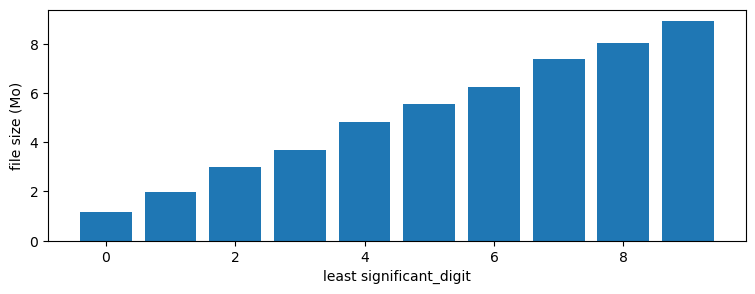

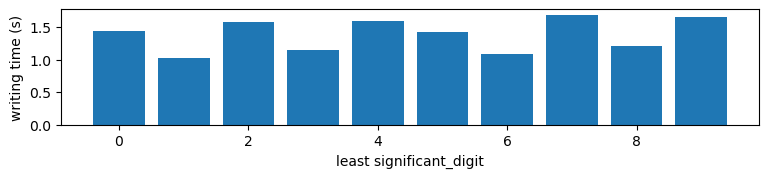

In [5]:
ls = list(range(10))
files_sizes_1, time_save = [], []

for ls_value in ls:
    encode_dataset(random_ds, least_significant_digit=ls_value)
    s, t = monitor_save_nc(random_ds)
    files_sizes_1.append(s)
    time_save.append(t)

plt.figure(figsize=(9, 3))
plt.bar(x=ls, height=files_sizes_1)
plt.xlabel('least significant_digit')
plt.ylabel('file size (Mo)')
plt.show()

plt.figure(figsize=(9, 1.5))
plt.bar(x=ls, height=time_save)
plt.xlabel('least significant_digit')
plt.ylabel('writing time (s)')
plt.show()

## 1.2. `complevel` effect

On the other hand, changing complevel from an intermediate value, such as between 4 or 6, is not particularly beneficial. High values of complevel can significantly increase writing time.

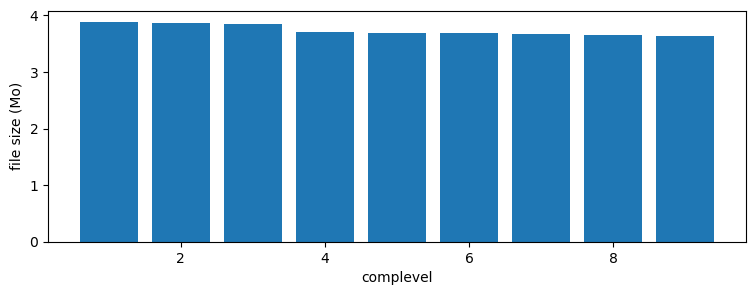

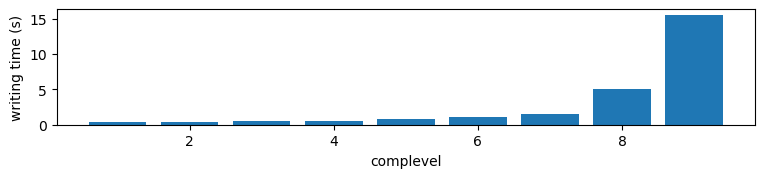

In [6]:
c = list(range(1, 10))
files_sizes, time_save = [], []

for c_value in c:
    encode_dataset(random_ds, least_significant_digit=3, complevel=c_value)
    s, t = monitor_save_nc(random_ds)
    files_sizes.append(s)
    time_save.append(t)

plt.figure(figsize=(9, 3))
plt.bar(x=c, height=files_sizes)
plt.xlabel('complevel')
plt.ylabel('file size (Mo)')
plt.show()

plt.figure(figsize=(9, 1.5))
plt.bar(x=c, height=time_save)
plt.xlabel('complevel')
plt.ylabel('writing time (s)')
plt.show()

# 2. `encode_dataset` applied to smooth fields

The zlib standard, combined with setting a least_significant_digits parameter, performs even better on data where values are correlated with their neighbors in any dimension.

In [7]:
def smooth_dataset(nt, ny, nx, nvars=3):
    alphabet = list(map(chr, range(97, 123)))

    def f(nt, ny, nx):
        x = np.linspace(-1, 1, nx)
        y = np.linspace(-1, 1, ny)
        ret = 3*(x[None, :, None]**2 + y[None, None, :]**2) + np.linspace(0, 2*np.pi, nt)[:, None, None]
        ret = np.cos(ret)
        return ret

    ds = {k: (('time', 'y', 'x'), f(nt, ny, nx)) for k in alphabet[:nvars]}
    ds = xr.Dataset(ds)
    return ds


smooth_ds = smooth_dataset(24, 150, 200)
smooth_ds

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 24, y: 200, x: 150)
Dimensions without coordinates: time, y, x
Data variables:
    a        (time, y, x) float64 6MB 0.9602 0.9348 0.9039 ... 0.9348 0.9602
    b        (time, y, x) float64 6MB 0.9602 0.9348 0.9039 ... 0.9348 0.9602
    c        (time, y, x) float64 6MB 0.9602 0.9348 0.9039 ... 0.9348 0.9602

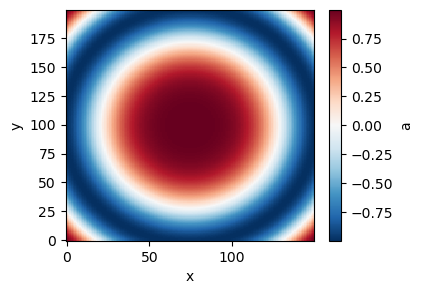

In [8]:
smooth_ds['a'].isel(time=0).plot(figsize=(4, 3))

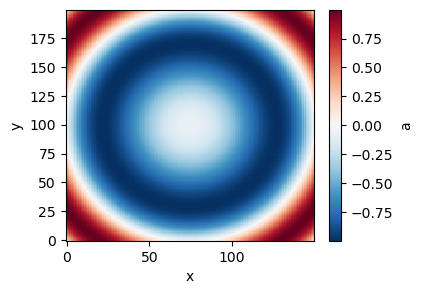

In [9]:
smooth_ds['a'].isel(time=6).plot(figsize=(4, 3))

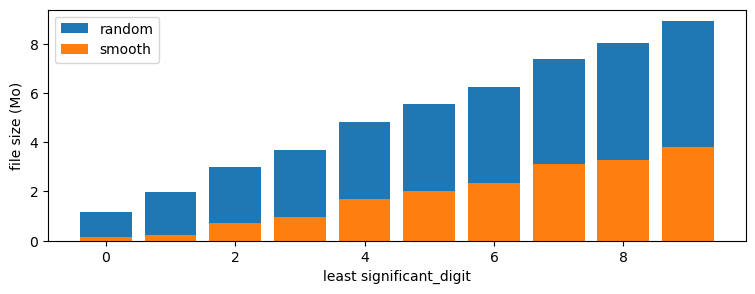

In [10]:
ls = list(range(10))
files_sizes_2 = []

for ls_value in ls:
    encode_dataset(smooth_ds, least_significant_digit=ls_value)
    s, _ = monitor_save_nc(smooth_ds)
    files_sizes_2.append(s)

plt.figure(figsize=(9, 3))
plt.bar(x=ls, height=files_sizes_1, label='random')
plt.bar(x=ls, height=files_sizes_2, label='smooth')
plt.xlabel('least significant_digit')
plt.ylabel('file size (Mo)')
plt.legend()
plt.show()